<a href="https://colab.research.google.com/github/alexandrumeterez/ai_notebooks/blob/master/LSTM_Variational_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import time
import math
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
%matplotlib inline

In [ ]:
torch.cuda.is_available()

True

In [ ]:
data_folder = "/content/drive/MyDrive/flx/data_imp1.csv"

In [ ]:
data = pd.read_csv(data_folder, index_col=0)
data = data.dropna()

In [ ]:
# I will batch by sitename
sites = data['sitename'].unique()
sites_df = [data[data['sitename'] == site] for site in sites]
for i in range(len(sites_df)):
    sites_df[i]['date'] = pd.to_datetime(sites_df[i]['date'], format="%Y-%m-%d")
    sites_df[i] = sites_df[i].set_index("date")
    sites_df[i] = sites_df[i].drop(columns=["sitename"])
    sites_df[i] = sites_df[i].reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
sites_df[0].columns

Index(['TA_F', 'SW_IN_F', 'LW_IN_F', 'VPD_F', 'PA_F', 'P_F', 'WS_F', 'USTAR',
       'CO2_F_MDS', 'GPP_NT_VUT_REF'],
      dtype='object')

In [ ]:
# Normalize the columns
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        result[feature_name] = (df[feature_name] - df[feature_name].mean()) / df[feature_name].std()
    return result
for i in range(len(sites_df)):
    sites_df[i] = normalize(sites_df[i])

In [ ]:
sites_to_train = list(range(0, 30))
site_to_test = [70]

train = [sites_df[i] for i in sites_to_train]
test = [sites_df[i] for i in site_to_test]

In [ ]:
# Split data in batches
def make_batches(array_of_sites, n_cols=9):
    X_seqs = []
    y_seqs = []
    batches = []
    for site in array_of_sites:
        values = site.to_numpy()
        X_values = values[:, 0:n_cols]
        y_values = values[:, n_cols]

        X_seqs.append(X_values)
        y_seqs.append(y_values)

    return X_seqs, y_seqs

In [ ]:
class MyDataset(Dataset):
    def __init__(self, x, y):
        super(MyDataset, self).__init__()
        self.x = x
        self.y = y

    def __len__(self):
        return self.y.shape[1]

    def __getitem__(self, index):
        return self.x[:, index, :], self.y[:, index]

In [ ]:
# seqlen, batchsize, n features
class Encoder(nn.Module):
    def __init__(self, n_features, hidden_size, hidden_layer_depth, dropout):
        super().__init__()
        self.n_features = n_features
        self.hidden_size = hidden_size
        self.hidden_layer_depth = hidden_layer_depth
        
        self.rnn = nn.LSTM(self.n_features, self.hidden_size, self.hidden_layer_depth, dropout = dropout)

    def forward(self, x):
        # x: (seq_len, batch size, n_features)
        _, (h_end, c_end) = self.rnn(x)
        return h_end[-1, :, :] #(batchsize, hidden_dim)

class Reparametrize(nn.Module):
    def __init__(self, hidden_size, latent_size, decoder_hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.decoder_hidden_size = decoder_hidden_size

        self.hidden_to_mean = nn.Linear(self.hidden_size, self.latent_size)
        self.hidden_to_logvar = nn.Linear(self.hidden_size, self.latent_size)
        self.latent_to_hidden = nn.Linear(self.latent_size, self.decoder_hidden_size)

        nn.init.xavier_uniform_(self.hidden_to_mean.weight)
        nn.init.xavier_uniform_(self.hidden_to_logvar.weight)

    def forward(self, x):
        self.mean = self.hidden_to_mean(x)
        self.logvar = self.hidden_to_logvar(x)

        std = torch.exp(0.5 * self.logvar)
        eps = torch.randn_like(std)
        z = eps.mul(std).add_(self.mean)
        return self.latent_to_hidden(z), z, self.mean, self.logvar

# Decoder to reconstruct the sequence
class Decoder_Reconstruct(nn.Module):
    def __init__(self, n_features, hidden_size, hidden_layer_depth):
        super().__init__()
        self.hidden_size = hidden_size
        self.hidden_layer_depth = hidden_layer_depth
        self.n_features = n_features
        
        self.rnn = nn.LSTM(self.n_features, self.hidden_size, self.hidden_layer_depth)
        self.hidden_to_output = nn.Linear(self.hidden_size, self.n_features)
    def forward(self, z, h_0, c_0):
        _, (h, c) = self.rnn(z, (h_0, c_0))
        prediction = self.hidden_to_output(h)
        return prediction, h, c

class VAE(nn.Module):
    def __init__(self, encoder, decoder, reparam, step, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.reparam = reparam
        self.device = device
        self.step = step #1 or 2

    def forward(self, x, y, teacher_forcing_ratio=0.5):
        seq_len = x.size(0)
        batch_size = x.size(1)
        n_features = x.size(2)
        h = self.encoder(x)
        hidden, latent, mu, logvar = self.reparam(h)

        decoder_input = torch.zeros((1, batch_size, n_features)).to(self.device)
        decoder_outputs = torch.zeros((seq_len, batch_size, n_features)).to(self.device)

        hidden = hidden.unsqueeze(0)
        c_0 = torch.zeros_like(hidden)

        h_ = hidden
        c_ = c_0

        for t in range(seq_len):
            prediction, h_, c_ = self.decoder(decoder_input, h_, c_)
            decoder_outputs[t, :, :] = prediction
            teacher_force = random.random() < teacher_forcing_ratio
            decoder_input = x[t, :, :].unsqueeze(0) if teacher_force else prediction
        return decoder_outputs, mu, logvar

In [ ]:
DEVICE = "cuda"
X_train, y_train = make_batches(train)
X_test, y_test = make_batches(test)


X_train = pad_sequence([torch.FloatTensor(x) for x in X_train])
X_test = pad_sequence([torch.FloatTensor(x) for x in X_test])

y_train = pad_sequence([torch.FloatTensor(y) for y in y_train])
y_test = pad_sequence([torch.FloatTensor(y) for y in y_test])

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(X_test, y_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, drop_last=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, num_workers=2)

N_FEATURES = 9
ENCODER_HIDDEN_SIZE = 128
ENCODER_HIDDEN_LAYER_DEPTH = 1
LATENT_SIZE = 256
DECODER_HIDDEN_SIZE = 128
DECODER_HIDDEN_LAYER_DEPTH = 1

encoder = Encoder(N_FEATURES, ENCODER_HIDDEN_SIZE, ENCODER_HIDDEN_LAYER_DEPTH, 0).to(DEVICE)
reparam = Reparametrize(ENCODER_HIDDEN_SIZE, LATENT_SIZE, DECODER_HIDDEN_SIZE).to(DEVICE)
decoder = Decoder_Reconstruct(N_FEATURES, DECODER_HIDDEN_SIZE, DECODER_HIDDEN_LAYER_DEPTH).to(DEVICE)
model = VAE(encoder, decoder, reparam, 1, DEVICE)

optimizer = torch.optim.Adam(model.parameters())

def loss_fn(x_decoded, x, mu, logvar):
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    recon_loss = F.mse_loss(x_decoded, x)
    return kl_loss + recon_loss, recon_loss, kl_loss

torch.Size([6940, 30, 9]) torch.Size([6940, 30]) torch.Size([3653, 1, 9]) torch.Size([3653, 1])


In [ ]:
model.step = 1
model.decoder = decoder
for epoch in range(500):
    train_loss = 0.0
    train_recon_loss = 0.0
    train_kl_loss = 0.0

    test_loss = 0.0
    test_recon_loss = 0.0
    test_kl_loss = 0.0

    model.train()
    start = time.time()
    for (x, y) in train_loader:        
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        x = x.permute(1, 0, 2)
        outputs, mu, logvar = model(x, y)
        outputs = outputs.permute(1, 0, 2)
        x = x.permute(1, 0, 2)
        
        optimizer.zero_grad()
        loss, recon_loss, kl_loss = loss_fn(outputs, x, mu, logvar)
        loss.backward()
        optimizer.step()    
        train_loss += loss.item()
        train_recon_loss += recon_loss.item()
        train_kl_loss += kl_loss.item()

    for (x, y) in test_loader:        
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        x = x.permute(1, 0, 2)
        outputs, mu, logvar = model(x, y)
        outputs = outputs.permute(1, 0, 2)
        x = x.permute(1, 0, 2)
        loss, recon_loss, kl_loss = loss_fn(outputs, x, mu, logvar)
        test_loss += loss.item()
        test_recon_loss += recon_loss.item()
        test_kl_loss += kl_loss.item()

    end = time.time()
    print(f"Training step: {model.step}")
    print(f"Epoch: {epoch + 1} ({end-start}s)")
    print(f"Train loss: {train_loss / len(train_loader)} | Train recon loss: {train_recon_loss / len(train_loader)} | Train KL loss: {train_kl_loss / len(train_loader)}")
    print(f"Test loss: {test_loss / len(test_loader)} | Test recon loss: {test_recon_loss / len(test_loader)} | Test KL loss: {test_kl_loss / len(test_loader)}")

Training step: 1
Epoch: 1 (55.33962392807007s)
Train loss: 0.42573678280626026 | Train recon loss: 0.4239083464656557 | Train KL loss: 0.0018284293057929193
Test loss: 0.9658552408218384 | Test recon loss: 0.9641176462173462 | Test KL loss: 0.0017376035684719682
Training step: 1
Epoch: 2 (55.56234407424927s)
Train loss: 0.40776646775858744 | Train recon loss: 0.4072827420064381 | Train KL loss: 0.0004837199646447386
Test loss: 0.8856214880943298 | Test recon loss: 0.884585440158844 | Test KL loss: 0.0010360204614698887
Training step: 1
Epoch: 3 (55.51307129859924s)
Train loss: 0.3643012408699308 | Train recon loss: 0.36414584517478943 | Train KL loss: 0.0001553988258820027
Test loss: 0.8136158585548401 | Test recon loss: 0.8127142190933228 | Test KL loss: 0.0009016143158078194
Training step: 1
Epoch: 4 (55.67759466171265s)
Train loss: 0.33241112743105206 | Train recon loss: 0.33234276941844393 | Train KL loss: 6.835920170747809e-05
Test loss: 0.7676153779029846 | Test recon loss: 0.766

KeyboardInterrupt: ignored

In [ ]:
model = model.to(DEVICE)
X_train = X_train.to(DEVICE)
y_train = y_train.to(DEVICE)
predictions, mu, logvar = model(X_train, y_train)

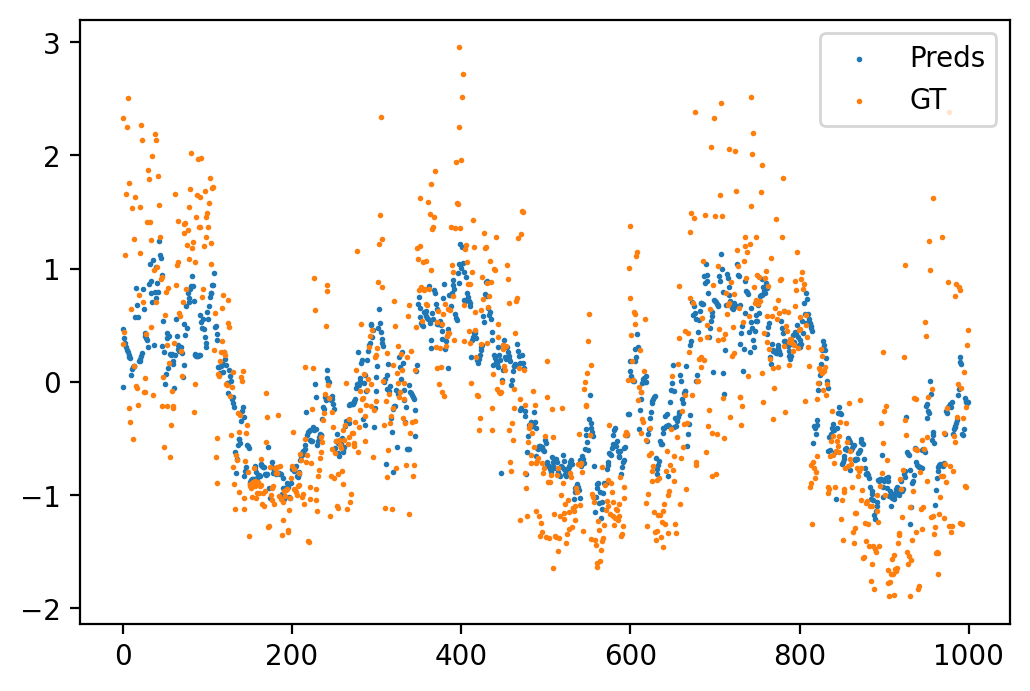

In [ ]:
site = 0
col = 3

x = X_train.detach().cpu().numpy()
# x = X_train.detach().cpu().numpy()
p = predictions.detach().cpu().numpy()

l = 1000
x_axis = range(l)

plt.figure(dpi=200)
plt.scatter(x=x_axis, y=p[:l, site, col], s=1, label="Preds")
plt.scatter(x=x_axis, y=x[:l, site, col], s=1, label="GT")
plt.legend()
plt.show()


In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
print(mu.shape)
x_ = tsne.fit_transform(mu.detach().cpu().numpy())

torch.Size([30, 256])


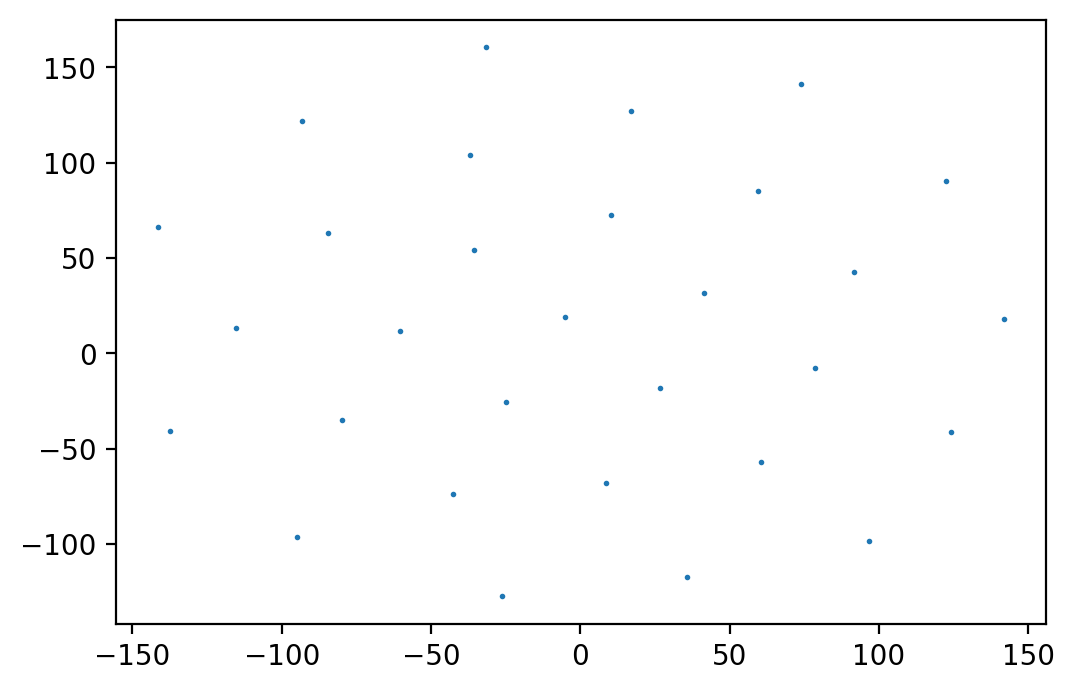

In [ ]:
plt.figure(dpi=200)
plt.scatter(x_[:,0], x_[:,1], s=1)
plt.show()

In [ ]:
sites[0:30]

array(['AR-Vir', 'AU-Ade', 'AU-ASM', 'AU-DaP', 'AU-DaS', 'AU-Dry',
       'AU-Fog', 'AU-Gin', 'AU-How', 'AU-Stp', 'AU-Whr', 'AU-Wom',
       'BE-Bra', 'BE-Vie', 'CH-Fru', 'CH-Lae', 'CH-Oe1', 'CN-Cng',
       'CN-Qia', 'CZ-wet', 'DE-Akm', 'DE-Geb', 'DE-Gri', 'DE-Hai',
       'DE-Kli', 'DE-Obe', 'DE-RuR', 'DE-Spw', 'DE-Tha', 'DK-NuF'],
      dtype=object)